# Capstone Project: Evaluating Food Restaurant Feasibility in London, United Kingdom using k-Means Clustering

## Table of Contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

Suppose a client wants to expand his Jollybuzz food corporation to Europe. He wanted to build his first store in London, United Kingdom. However, he has little knowledge on areas and neighbourhood in the city. He also wants to know where are his competitors are located and where are the areas with least competition.

In addition, we will evaluate which value of k has the highest model accuracy in identifying clusters of neighbourhoods in London. After determining the target neighborhood cluster, we will profile the cluster based on demography and predict two-year business survival rate in the cluster.

## Data <a name="Data"></a>

We will need to get information on:
* List of Neighbourhood in London, United Kingdom
* Post codes and location of the neighbourhoods
* Venues in the neighbourhood
* London Borough Profile

There will be four sources of data:

1. List of Neighbourhood(Areas) in London - https://en.wikipedia.org/wiki/List_of_areas_of_London </li>
    This contains Location which will be the neighborhood, area which is the borough.
2. Post codes and Location data - https://www.doogal.co.uk/AdministrativeAreas.php </li>
    This contains the borough list with latitude and longitude values.
3. Venues in the neighbourhood - Foursquare API </li>
    To be extracted from Foursquare API
4. London Borough profiles - https://data.london.gov.uk/dataset/london-borough-profiles#:~:text=The%20London%20Borough%20Profiles%20help,borough%2C%20alongside%20relevant%20comparator%20areas. </li>
    Compute for Average two-year business survival rate in London and create new variable where value is equal to 1 if two-year business survival rate is above average and 0 otherwise. </li>
   </li> Use this as dependent variable and run using decision tree and logistic regression to identify significant factors affecting in the target cluster to their business survival.
 

### Importing Libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import re

#conda install -c conda-forge kneed
from kneed import KneeLocator

from sklearn.cluster import KMeans


print('Libraries imported.')

Libraries imported.


### Webscraping List of Neighbourhoods in London

In [2]:
url  = 'https://en.wikipedia.org/wiki/List_of_areas_of_London'
df_list = pd.read_html(url)

# get 1st array which contains list of the neighbourhood
df_list[1]

Location  \
0                                        Abbey Wood   
1                                             Acton   
2                                         Addington   
3                                        Addiscombe   
4                                       Albany Park   
5                                  Aldborough Hatch   
6                                           Aldgate   
7                                           Aldwych   
8                                          Alperton   
9                                           Anerley   
10                                            Angel   
11                                        Aperfield   
12                                          Archway   
13                                   Ardleigh Green   
14                                           Arkley   
15                                      Arnos Grove   
16                                           Balham   
17                                         Bankside   
18                                         Barbican   
19                                          Barking   
20                                      Barkingside   
21                                       Barnehurst   
22                                           Barnes   
23                                      Barnes Cray   
24                                      Barnet Gate   
25       Barnet (also Chipping Barnet, High Barnet)   
26                                        Barnsbury   
27                                        Battersea   
28                                        Bayswater   
29                                        Beckenham   
30                                          Beckton   
31                                        Becontree   
32                                  Becontree Heath   
33                                       Beddington   
34                                     Bedford Park   
35                                        Belgravia   
36                                       Bellingham   
37                                          Belmont   
38                                          Belmont   
39                                     Belsize Park   
40                                        Belvedere   
41                                       Bermondsey   
42                                       Berrylands   
43                                    Bethnal Green   
44         Bexley (also Old Bexley, Bexley Village)   
45               Bexleyheath (also Bexley New Town)   
46                                          Bickley   
47                                      Biggin Hill   
48                                         Blackfen   
49                                      Blackfriars   
50                                       Blackheath   
51                        Blackheath Royal Standard   
52                                        Blackwall   
53                                          Blendon   
54                                       Bloomsbury   
55                                       Botany Bay   
56                                     Bounds Green   
57                                              Bow   
58                                       Bowes Park   
59                                        Brentford   
60                                      Brent Cross   
61                                       Brent Park   
62                                        Brimsdown   
63                                          Brixton   
64                                         Brockley   
65                                          Bromley   
66                    Bromley (also Bromley-by-Bow)   
67                                   Bromley Common   
68                                         Brompton   
69                                      Brondesbury   
70                                   Brunswick Park   
71                                      Bulls Cross   
72                          

In [3]:
colnames = ['Neighborhood', 'Borough', 'Post_town','Postcode', 'Dial code']
ldn = pd.DataFrame(df_list[1])
ldn.drop(columns =["OS grid ref"], axis = 1, inplace = True)
ldn.columns=colnames
ldn.drop(columns =["Dial code"], axis = 1, inplace = True)

ldn.head()


Neighborhood                            Borough       Post_town   Postcode
0   Abbey Wood              Bexley, Greenwich [7]          LONDON        SE2
1        Acton  Ealing, Hammersmith and Fulham[8]          LONDON     W3, W4
2    Addington                         Croydon[8]         CROYDON        CR0
3   Addiscombe                         Croydon[8]         CROYDON        CR0
4  Albany Park                             Bexley  BEXLEY, SIDCUP  DA5, DA14

In [4]:
#remove subscripts in Borough column
ldn['Borough']=ldn.Borough.str.replace('[^a-zA-Z, ]', "")
ldn.head()

Neighborhood                         Borough       Post_town   Postcode
0   Abbey Wood              Bexley, Greenwich           LONDON        SE2
1        Acton  Ealing, Hammersmith and Fulham          LONDON     W3, W4
2    Addington                         Croydon         CROYDON        CR0
3   Addiscombe                         Croydon         CROYDON        CR0
4  Albany Park                          Bexley  BEXLEY, SIDCUP  DA5, DA14

In [5]:
#split Boroughs and expand so that, one borough = one line
ldn['Borough1'] = ldn['Borough'].str.split(',',expand = True).get(0)
ldn['Borough2'] = ldn['Borough'].str.split(',',expand = True).get(1)
ldn.head()

Neighborhood                         Borough       Post_town   Postcode  \
0   Abbey Wood              Bexley, Greenwich           LONDON        SE2   
1        Acton  Ealing, Hammersmith and Fulham          LONDON     W3, W4   
2    Addington                         Croydon         CROYDON        CR0   
3   Addiscombe                         Croydon         CROYDON        CR0   
4  Albany Park                          Bexley  BEXLEY, SIDCUP  DA5, DA14   

  Borough1                 Borough2  
0   Bexley               Greenwich   
1   Ealing   Hammersmith and Fulham  
2  Croydon                     None  
3  Croydon                     None  
4   Bexley                     None

In [6]:
ldn1 = ldn[['Neighborhood', 'Borough1']]
ldn2 = ldn[['Neighborhood', 'Borough2']]
ldn1.columns = ['Neighborhood', 'Borough']
ldn2.columns = ['Neighborhood', 'Borough']
ldnf = ldn1.append( ldn2)
ldnf = ldnf[ldnf['Borough'].notnull()]
ldnf.sort_values(by = ['Borough'], inplace = True)
ldnf

Neighborhood  \
85                                   Chadwell Heath   
121                                     Cricklewood   
379                                      Queensbury   
479                                    Upper Ruxley   
454  Sydenham (also Lower Sydenham, Upper Sydenham)   
392                                          Ruxley   
470                                    Tufnell Park   
268                                         Kilburn   
358                                      Park Royal   
99                                         Chiswick   
448                                         Sudbury   
104                                     Cockfosters   
459                                      Thamesmead   
168                                      Falconwood   
0                                        Abbey Wood   
1                                             Acton   
264                                          Kenton   
173                                   Finsbury Park   
529                                  Worcester Park   
249                                       Horn Park   
260                                      Kennington   
455                                   Sydenham Hill   
524                                  Woodford Green   
409                                     Snaresbrook   
102                                         Clapham   
457                                          Temple   
19                                          Barking   
391                                      Rush Green   
131                                        Dagenham   
32                                  Becontree Heath   
31                                        Becontree   
83                                     Castle Green   
119                                      Creekmouth   
300                                      Marks Gate   
234                                          Hendon   
211                         Hampstead Garden Suburb   
253                                        The Hyde   
207                                        The Hale   
193                                    Grahame Park   
60                                      Brent Cross   
190                                   Golders Green   
181                                   Friern Barnet   
148                                   East Finchley   
70                                   Brunswick Park   
72                                        Burnt Oak   
73                                   Burroughs, The   
154                                         Edgware   
145                                     East Barnet   
121                                     Cricklewood   
108                                    Colney Hatch   
105                                       Colindale   
104                                     Cockfosters   
171                                        Finchley   
308                                       Mill Hill   
353                                          Osidge   
322                                      New Barnet   
14                                           Arkley   
24                                      Barnet Gate   
25       Barnet (also Chipping Barnet, High Barnet)   
527                                   Woodside Park   
514                                       Whetstone   
508                                     West Hendon   
312                                   Monken Hadley   
458                                  Temple Fortune   
101                                      Church End   
468                                      Totteridge   
94                                      Childs Hill   
326                                   New Southgate   
335                                  North Finchley   
347                                   Oakleigh Park   
292                                       Longlands   
282                                  Lessness Heath   
109                     

### Webscraping location data

In [7]:
url  = 'https://www.doogal.co.uk/AdministrativeAreas.php'
df_list2 = pd.read_html(url)
df_list2[0]

Administrative area                    County  Latitude  \
0                           Aberdeen City                       NaN   57.1495   
1                           Aberdeenshire                       NaN   57.3539   
2                                    Adur               West Sussex   50.8332   
3                               Allerdale                   Cumbria   54.7132   
4                            Amber Valley                Derbyshire   53.0377   
5                                   Angus                       NaN   56.6195   
6                 Antrim and Newtownabbey                       NaN   54.6982   
7                     Ards and North Down                       NaN   54.6072   
8                         Argyll and Bute                       NaN   56.0324   
9    Armagh City, Banbridge and Craigavon                       NaN   54.3849   
10                                   Arun               West Sussex   50.8087   
11                               Ashfield           Nottinghamshire   53.0874   
12                                Ashford                      Kent   51.1354   
13                                Babergh                   Suffolk   52.0389   
14                   Barking and Dagenham            Greater London   51.5465   
15                                 Barnet            Greater London   51.6055   
16                               Barnsley           South Yorkshire   53.5463   
17                      Barrow-in-Furness                   Cumbria   54.1263   
18                               Basildon                     Essex   51.5901   
19                  Basingstoke and Deane                 Hampshire   51.2870   
20                              Bassetlaw           Nottinghamshire   53.3318   
21           Bath and North East Somerset                  Somerset   51.3641   
22                                Bedford              Bedfordshire   52.1446   
23                                Belfast                       NaN   54.5934   
24                                 Bexley            Greater London   51.4592   
25                             Birmingham             West Midlands   52.4809   
26                                  Blaby            Leicestershire   52.5884   
27                  Blackburn with Darwen                Lancashire   53.7292   
28                              Blackpool                Lancashire   53.8176   
29                          Blaenau Gwent                       NaN   51.7676   
30                               Bolsover                Derbyshire   53.2072   
31                                 Bolton        Greater Manchester   53.5774   
32                                 Boston              Lincolnshire   52.9702   
33    Bournemouth, Christchurch and Poole                    Dorset   50.7358   
34                       Bracknell Forest                 Berkshire   51.4013   
35                               Bradford            West Yorkshire   53.8214   
36                              Braintree                     Essex   51.8886   
37                              Breckland                   Norfolk   52.5809   
38                                  Brent            Greater London   51.5518   
39                              Brentwood                     Essex   51.6309   
40                               Bridgend                       NaN   51.5316   
41                      Brighton and Hove               East Sussex   50.8322   
42                       Bristol, City of                   Bristol   51.4606   
43                              Broadland                   Norfolk   52.6740   
44                                Bromley            Greater London   51.3918   
45                             Bromsgrove            Worcestershire   52.3557   
46                             Broxbourne             Hertfordshire   51.7240   
47                               Broxtowe           Nottinghamshire   52.9548   
48                        Buckinghamshire           B

Convert to webscraped data into pandas data frame.

In [8]:
#convert to data frame
ll = pd.DataFrame(df_list2[0])
ll = ll.filter(items = ['Administrative area',  'Latitude', 'Longitude'])
ll.columns = ['Borough', 'Latitude', 'Longitude']
ll.head()

Borough  Latitude  Longitude
0  Aberdeen City   57.1495  -2.132950
1  Aberdeenshire   57.3539  -2.322430
2           Adur   50.8332  -0.284433
3      Allerdale   54.7132  -3.361390
4   Amber Valley   53.0377  -1.424350

Merge Location data and Neighborhood data. 

In [9]:
##combine location data and neighborhood data
ldnf_ll = pd.merge(ldnf, ll, on = "Borough")
ldnf_ll

Neighborhood                 Borough  \
0                                           Barking    Barking and Dagenham   
1                                        Rush Green    Barking and Dagenham   
2                                          Dagenham    Barking and Dagenham   
3                                   Becontree Heath    Barking and Dagenham   
4                                         Becontree    Barking and Dagenham   
5                                      Castle Green    Barking and Dagenham   
6                                        Creekmouth    Barking and Dagenham   
7                                        Marks Gate    Barking and Dagenham   
8                                            Hendon                  Barnet   
9                           Hampstead Garden Suburb                  Barnet   
10                                         The Hyde                  Barnet   
11                                         The Hale                  Barnet   
12                                     Grahame Park                  Barnet   
13                                      Brent Cross                  Barnet   
14                                    Golders Green                  Barnet   
15                                    Friern Barnet                  Barnet   
16                                    East Finchley                  Barnet   
17                                   Brunswick Park                  Barnet   
18                                        Burnt Oak                  Barnet   
19                                   Burroughs, The                  Barnet   
20                                          Edgware                  Barnet   
21                                      East Barnet                  Barnet   
22                                      Cricklewood                  Barnet   
23                                     Colney Hatch                  Barnet   
24                                        Colindale                  Barnet   
25                                      Cockfosters                  Barnet   
26                                         Finchley                  Barnet   
27                                        Mill Hill                  Barnet   
28                                           Osidge                  Barnet   
29                                       New Barnet                  Barnet   
30                                           Arkley                  Barnet   
31                                      Barnet Gate                  Barnet   
32       Barnet (also Chipping Barnet, High Barnet)                  Barnet   
33                                    Woodside Park                  Barnet   
34                                        Whetstone                  Barnet   
35                                      West Hendon                  Barnet   
36                                    Monken Hadley                  Barnet   
37                                   Temple Fortune                  Barnet   
38                                       Church End                  Barnet   
39                                       Totteridge                  Barnet   
40                                      Childs Hill                  Barnet   
41                                    New Southgate                  Barnet   
42                                   North Finchley                  Barnet   
43                                    Oakleigh Park                  Barnet   
44                                        Longlands                  Bexley   
45                                   Lessness Heath                  Bexley   
46                                          Colyers                  Bexley   
47                                         Crayford                  Bexley   
48                                         Lamorbey                  Bexley   
49                                       North Cray                  Bexley   
50        

### Creating a Map of London, United Kingdom superimposed on top

In [10]:
address = "London"

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 51.5073219, -0.1276474.


In [11]:
map_london = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, borough, neighborhood in zip(ldnf_ll['Latitude'], ldnf_ll['Longitude'], ldnf_ll['Borough'], ldnf_ll['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london)
map_london

### Foursquare credentials

In [12]:
CLIENT_ID = 'RHJPVBEARK2NL5NCWS4HPHPDXAEMZTIRHGKGOREX1DD3PA2U' # your Foursquare ID
CLIENT_SECRET = 'W3YBXTKR2ZNEQ1YNOJAI2AAZH3RFVJNCPEU3F1LDI52R1EIH' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: RHJPVBEARK2NL5NCWS4HPHPDXAEMZTIRHGKGOREX1DD3PA2U
CLIENT_SECRET:W3YBXTKR2ZNEQ1YNOJAI2AAZH3RFVJNCPEU3F1LDI52R1EIH


In [13]:
neighborhood_latitude = ldnf_ll.loc[0,'Latitude']
neighborhood_longitude = ldnf_ll.loc[0,'Longitude']

neighborhood_name = ldnf_ll.loc[0, 'Neighborhood']

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Barking are 51.5465, 0.12498599999999999.


In [14]:
LIMIT = 100
radius = 500
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=RHJPVBEARK2NL5NCWS4HPHPDXAEMZTIRHGKGOREX1DD3PA2U&client_secret=W3YBXTKR2ZNEQ1YNOJAI2AAZH3RFVJNCPEU3F1LDI52R1EIH&v=20180605&ll=51.5465,0.12498599999999999&radius=500&limit=100'

In [15]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5f55bf07bf4f7117506e192d'},
 'response': {'warning': {'text': "There aren't a lot of results near you. Try something more general, reset your filters, or expand the search area."},
  'headerLocation': 'Barking and Dagenham',
  'headerFullLocation': 'Barking and Dagenham, London',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 2,
  'suggestedBounds': {'ne': {'lat': 51.551000004500004,
    'lng': 0.13220862759327937},
   'sw': {'lat': 51.5419999955, 'lng': 0.1177633724067206}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4e272db2149503e3719dec1a',
       'name': 'Parsloes Park',
       'location': {'address': 'Parsloes Ave.',
        'crossStreet': 'at  Gale St',
        'lat': 51.54502708490598,
        'lng': 0.1

In [16]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [17]:
venues = results['response']['groups'][0]['items']

    
nearby_venues = pd.json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

name    categories        lat       lng
0  Parsloes Park          Park  51.545027  0.125598
1         Dr Gas  Home Service  51.549740  0.121080

In [18]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [19]:
london_venues = getNearbyVenues(names=ldnf_ll['Neighborhood'],
                                   latitudes=ldnf_ll['Latitude'],
                                   longitudes=ldnf_ll['Longitude']
                                  )

Barking
Rush Green
Dagenham
Becontree Heath
Becontree
Castle Green
Creekmouth
Marks Gate
Hendon
Hampstead Garden Suburb
The Hyde
The Hale
Grahame Park
Brent Cross
Golders Green
Friern Barnet
East Finchley
Brunswick Park
Burnt Oak
Burroughs, The
Edgware
East Barnet
Cricklewood
Colney Hatch
Colindale
Cockfosters
Finchley
Mill Hill
Osidge
New Barnet
Arkley
Barnet Gate
Barnet (also Chipping Barnet, High Barnet)
Woodside Park
Whetstone
West Hendon
Monken Hadley
Temple Fortune
Church End
Totteridge
Childs Hill
New Southgate
North Finchley
Oakleigh Park
Longlands
Lessness Heath
Colyers
Crayford
Lamorbey
North Cray
North End
Crook Log
Crossness
Ruxley
Upton
East Wickham
Upper Ruxley
Erith
Thamesmead
Falconwood
Northumberland Heath
Slade Green
Foots Cray
Sidcup
West Heath
Welling
Abbey Wood
Albany Park
Barnehurst
Bexleyheath (also Bexley New Town)
Barnes Cray
Belvedere
Bexley (also Old Bexley, Bexley Village)
Blackfen
Blendon
Tokyngton
Preston
Dollis Hill
Willesden
Stonebridge
Sudbury
Kilburn
K

In [20]:
print(london_venues.shape)
london_venues.head()

(10830, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude          Venue  \
0      Barking                51.5465                0.124986  Parsloes Park   
1      Barking                51.5465                0.124986         Dr Gas   
2   Rush Green                51.5465                0.124986  Parsloes Park   
3   Rush Green                51.5465                0.124986         Dr Gas   
4     Dagenham                51.5465                0.124986  Parsloes Park   

   Venue Latitude  Venue Longitude Venue Category  
0       51.545027         0.125598           Park  
1       51.549740         0.121080   Home Service  
2       51.545027         0.125598           Park  
3       51.549740         0.121080   Home Service  
4       51.545027         0.125598           Park

Now, let's check enue counts per neighborhood.

In [21]:
london_venues.groupby('Neighborhood').count()

Neighborhood Latitude  \
Neighborhood                                                            
Abbey Wood                                                         15   
Acton                                                               3   
Addington                                                          32   
Addiscombe                                                         32   
Albany Park                                                        15   
Aldborough Hatch                                                   17   
Aldwych                                                           100   
Alperton                                                            7   
Anerley                                                             3   
Angel                                                              57   
Aperfield                                                           3   
Archway                                                            57   
Ardleigh Green                                                      1   
Arkley                                                              6   
Arnos Grove                                                         4   
Balham                                                             12   
Bankside                                                           10   
Barking                                                             2   
Barkingside                                                        17   
Barnehurst                                                         15   
Barnes                                                             14   
Barnes Cray                                                        15   
Barnet (also Chipping Barnet, High Barnet)                          6   
Barnet Gate                                                         6   
Barnsbury                                                          57   
Battersea                                                          12   
Bayswater                                                         100   
Beckenham                                                           3   
Beckton                                                             6   
Becontree                                                           2   
Becontree Heath                                                     2   
Beddington                                                          5   
Bedford Park                                                        3   
Belgravia                                                         100   
Bellingham                                                          7   
Belmont                                                            10   
Belsize Park                                                       87   
Belvedere                                                          15   
Bermondsey                                                         10   
Berrylands                                                          5   
Bethnal Green                                                      13   
Bexley (also Old Bexley, Bexley Village)                           15   
Bexleyheath (also Bexley New Town)                                 15   
Bickley                                                             3   
Biggin Hill                                                         3   
Blackfen                                                           15   
Blackheath                                                          7   
Blackheath Royal Standard                                           5   
Blackwall                                                          13   
Blendon                                                            15   
Bloomsbury                                                         87   
Botany Bay                                                          4   
Bounds Green                                                       39   
Bow                              

In [22]:
print('There are {} uniques categories.'.format(len(london_venues['Venue Category'].unique())))

There are 173 uniques categories.


### Analyzing Neighborhood and Venues around it. 

In [23]:
# one hot encoding
london_onehot = pd.get_dummies(london_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
london_onehot['Neighborhood'] = london_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [london_onehot.columns[-1]] + list(london_onehot.columns[:-1])
london_onehot = london_onehot[fixed_columns]

london_onehot.head()

Neighborhood  Afghan Restaurant  African Restaurant  American Restaurant  \
0      Barking                  0                   0                    0   
1      Barking                  0                   0                    0   
2   Rush Green                  0                   0                    0   
3   Rush Green                  0                   0                    0   
4     Dagenham                  0                   0                    0   

   Argentinian Restaurant  Art Gallery  Art Museum  Asian Restaurant  \
0                       0            0           0                 0   
1                       0            0           0                 0   
2                       0            0           0                 0   
3                       0            0           0                 0   
4                       0            0           0                 0   

   Athletics & Sports  BBQ Joint  Bakery  Bar  Beer Bar  Beer Garden  Bistro  \
0                   0          0       0    0         0            0       0   
1                   0          0       0    0         0            0       0   
2                   0          0       0    0         0            0       0   
3                   0          0       0    0         0            0       0   
4                   0          0       0    0         0            0       0   

   Boat or Ferry  Bookstore  Boutique  Breakfast Spot  Brewery  Building  \
0              0          0         0               0        0         0   
1              0          0         0               0        0         0   
2              0          0         0               0        0         0   
3              0          0         0               0        0         0   
4              0          0         0               0        0         0   

   Bulgarian Restaurant  Burger Joint  Burrito Place  Bus Stop  \
0                     0             0              0         0   
1                     0             0              0         0   
2                     0             0              0         0   
3                     0             0              0         0   
4                     0             0              0         0   

   Business Service  Café  Camera Store  Cantonese Restaurant  \
0                 0     0             0                     0   
1                 0     0             0                     0   
2                 0     0             0                     0   
3                 0     0             0                     0   
4                 0     0             0                     0   

   Caribbean Restaurant  Chinese Restaurant  Chocolate Shop  Clothing Store  \
0                     0                   0               0               0   
1                     0                   0               0               0   
2                     0                   0               0               0   
3                     0                   0               0               0   
4                     0                   0               0               0   

   Cocktail Bar  Coffee Shop  Concert Hall  Construction & Landscaping  \
0             0            0             0                           0   
1             0            0             0                           0   
2             0            0             0                           0   
3             0            0             0                           0   
4             0            0             0                           0   

   Convenience Store  Cosmetics Shop  Cuban Restaurant  Cupcake Shop  \
0                  0               0                 0             0   
1                  0               0                 0             0   
2                  0               0                 0             0   
3                  0               0                 0             0   
4                  0               0                 0             0   

   Deli / Bodega  Dep

In [24]:
london_grouped = london_onehot.groupby('Neighborhood').mean().reset_index()
london_grouped

Neighborhood  Afghan Restaurant  \
0                                        Abbey Wood                0.0   
1                                             Acton                0.0   
2                                         Addington                0.0   
3                                        Addiscombe                0.0   
4                                       Albany Park                0.0   
5                                  Aldborough Hatch                0.0   
6                                           Aldwych                0.0   
7                                          Alperton                0.0   
8                                           Anerley                0.0   
9                                             Angel                0.0   
10                                        Aperfield                0.0   
11                                          Archway                0.0   
12                                   Ardleigh Green                0.0   
13                                           Arkley                0.0   
14                                      Arnos Grove                0.0   
15                                           Balham                0.0   
16                                         Bankside                0.0   
17                                          Barking                0.0   
18                                      Barkingside                0.0   
19                                       Barnehurst                0.0   
20                                           Barnes                0.0   
21                                      Barnes Cray                0.0   
22       Barnet (also Chipping Barnet, High Barnet)                0.0   
23                                      Barnet Gate                0.0   
24                                        Barnsbury                0.0   
25                                        Battersea                0.0   
26                                        Bayswater                0.0   
27                                        Beckenham                0.0   
28                                          Beckton                0.0   
29                                        Becontree                0.0   
30                                  Becontree Heath                0.0   
31                                       Beddington                0.0   
32                                     Bedford Park                0.0   
33                                        Belgravia                0.0   
34                                       Bellingham                0.0   
35                                          Belmont                0.1   
36                                     Belsize Park                0.0   
37                                        Belvedere                0.0   
38                                       Bermondsey                0.0   
39                                       Berrylands                0.0   
40                                    Bethnal Green                0.0   
41         Bexley (also Old Bexley, Bexley Village)                0.0   
42               Bexleyheath (also Bexley New Town)                0.0   
43                                          Bickley                0.0   
44                                      Biggin Hill                0.0   
45                                         Blackfen                0.0   
46                                       Blackheath                0.0   
47                        Blackheath Royal Standard                0.0   
48                                        Blackwall                0.0   
49                                          Blendon                0.0   
50                                       Bloomsbury                0.0   
51                                       Botany Bay                0.0   
52                                     Bounds Green                0.0   
53                                         

In [25]:
num_top_venues = 5

for hood in london_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = london_grouped[london_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Abbey Wood----
              venue  freq
0               Pub  0.20
1       Supermarket  0.13
2               Bar  0.07
3         Nightclub  0.07
4  Business Service  0.07


----Acton----
           venue  freq
0  Train Station  0.33
1           Park  0.33
2     Playground  0.33
3       Platform  0.00
4      Nightclub  0.00


----Addington----
                      venue  freq
0                       Pub  0.19
1  Mediterranean Restaurant  0.09
2        Italian Restaurant  0.09
3         Indian Restaurant  0.06
4                      Café  0.03


----Addiscombe----
                      venue  freq
0                       Pub  0.19
1  Mediterranean Restaurant  0.09
2        Italian Restaurant  0.09
3         Indian Restaurant  0.06
4                      Café  0.03


----Albany Park----
              venue  freq
0               Pub  0.20
1       Supermarket  0.13
2               Bar  0.07
3         Nightclub  0.07
4  Business Service  0.07


----Aldborough Hatch----
               ve

In [26]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [27]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = london_grouped['Neighborhood']

for ind in np.arange(london_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(london_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0   Abbey Wood                   Pub           Supermarket   
1        Acton                  Park            Playground   
2    Addington                   Pub    Italian Restaurant   
3   Addiscombe                   Pub    Italian Restaurant   
4  Albany Park                   Pub           Supermarket   

      3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0                       Bar     Recreation Center           Pizza Place   
1             Train Station           Yoga Studio     Fish & Chips Shop   
2  Mediterranean Restaurant     Indian Restaurant                Bistro   
3  Mediterranean Restaurant     Indian Restaurant                Bistro   
4                       Bar     Recreation Center           Pizza Place   

  6th Most Common Venue   7th Most Common Venue    8th Most Common Venue  \
0  Fast Food Restaurant               Nightclub       Chinese Restaurant   
1           Gaming Cafe  Furniture / Home Store  Fruit & Vegetable Store   
2                  Park                  Museum       Spanish Restaurant   
3                  Park                  Museum       Spanish Restaurant   
4  Fast Food Restaurant               Nightclub       Chinese Restaurant   

  9th Most Common Venue  10th Most Common Venue  
0      Business Service  Thrift / Vintage Store  
1   Fried Chicken Joint       French Restaurant  
2                  Café             Gaming Cafe  
3                  Café             Gaming Cafe  
4      Business Service  Thrift / Vintage Store

In [28]:
london_grouped.head()

Neighborhood  Afghan Restaurant  African Restaurant  American Restaurant  \
0   Abbey Wood                0.0                 0.0             0.066667   
1        Acton                0.0                 0.0             0.000000   
2    Addington                0.0                 0.0             0.000000   
3   Addiscombe                0.0                 0.0             0.000000   
4  Albany Park                0.0                 0.0             0.066667   

   Argentinian Restaurant  Art Gallery  Art Museum  Asian Restaurant  \
0                     0.0          0.0         0.0               0.0   
1                     0.0          0.0         0.0               0.0   
2                     0.0          0.0         0.0               0.0   
3                     0.0          0.0         0.0               0.0   
4                     0.0          0.0         0.0               0.0   

   Athletics & Sports  BBQ Joint  Bakery       Bar  Beer Bar  Beer Garden  \
0                 0.0        0.0     0.0  0.066667       0.0          0.0   
1                 0.0        0.0     0.0  0.000000       0.0          0.0   
2                 0.0        0.0     0.0  0.031250       0.0          0.0   
3                 0.0        0.0     0.0  0.031250       0.0          0.0   
4                 0.0        0.0     0.0  0.066667       0.0          0.0   

    Bistro  Boat or Ferry  Bookstore  Boutique  Breakfast Spot  Brewery  \
0  0.00000            0.0        0.0       0.0             0.0      0.0   
1  0.00000            0.0        0.0       0.0             0.0      0.0   
2  0.03125            0.0        0.0       0.0             0.0      0.0   
3  0.03125            0.0        0.0       0.0             0.0      0.0   
4  0.00000            0.0        0.0       0.0             0.0      0.0   

   Building  Bulgarian Restaurant  Burger Joint  Burrito Place  Bus Stop  \
0       0.0                   0.0           0.0            0.0       0.0   
1       0.0                   0.0           0.0            0.0       0.0   
2       0.0                   0.0           0.0            0.0       0.0   
3       0.0                   0.0           0.0            0.0       0.0   
4       0.0                   0.0           0.0            0.0       0.0   

   Business Service     Café  Camera Store  Cantonese Restaurant  \
0          0.066667  0.00000           0.0                   0.0   
1          0.000000  0.00000           0.0                   0.0   
2          0.000000  0.03125           0.0                   0.0   
3          0.000000  0.03125           0.0                   0.0   
4          0.066667  0.00000           0.0                   0.0   

   Caribbean Restaurant  Chinese Restaurant  Chocolate Shop  Clothing Store  \
0                   0.0            0.066667             0.0             0.0   
1                   0.0            0.000000             0.0             0.0   
2                   0.0            0.000000             0.0             0.0   
3                   0.0            0.000000             0.0             0.0   
4                   0.0            0.066667             0.0             0.0   

   Cocktail Bar  Coffee Shop  Concert Hall  Construction & Landscaping  \
0           0.0      0.00000       0.00000                         0.0   
1           0.0      0.00000       0.00000                         0.0   
2           0.0      0.03125       0.03125                         0.0   
3           0.0      0.03125       0.03125                         0.0   
4           0.0      0.00000       0.00000                         0.0   

   Convenience Store  Cosmetics Shop  Cuban Restaurant  Cupcake Shop  \
0                0.0             0.0               0.0           0.0   
1                0.0             0.0               0.0           0.0   
2                0.0             0.0               0.0           0.0   
3                0.0             0.0               0.0           0.0   
4                0.0             0.0    

### Demography Data Cleaning

In [29]:
url2  = 'https://data.london.gov.uk/download/london-borough-profiles/c1693b82-68b1-44ee-beb2-3decf17dc1f8/london-borough-profiles.csv'
demo = pd.read_csv(url2, engine='python')

In [30]:
demo.head()

Code             Area_name Inner/_Outer_London  \
0  E09000001        City of London        Inner London   
1  E09000002  Barking and Dagenham        Outer London   
2  E09000003                Barnet        Outer London   
3  E09000004                Bexley        Outer London   
4  E09000005                 Brent        Outer London   

   GLA_Population_Estimate_2017 GLA_Household_Estimate_2017  \
0                          8800                        5326   
1                        209000                       78188   
2                        389600                      151423   
3                        244300                       97736   
4                        332100                      121048   

  Inland_Area_(Hectares) Population_density_(per_hectare)_2017  \
0                    290                                  30.3   
1                  3,611                                  57.9   
2                  8,675                                  44.9   
3                  6,058                                  40.3   
4                  4,323                                  76.8   

   Average_Age,_2017  Proportion_of_population_aged_0-15,_2015  \
0               43.2                                      11.4   
1               32.9                                      27.2   
2               37.3                                      21.1   
3               39.0                                      20.6   
4               35.6                                      20.9   

   Proportion_of_population_of_working-age,_2015  \
0                                           73.1   
1                                           63.1   
2                                           64.9   
3                                           62.9   
4                                           67.8   

   Proportion_of_population_aged_65_and_over,_2015  \
0                                             15.5   
1                                              9.7   
2                                             14.0   
3                                             16.6   
4                                             11.3   

  Net_internal_migration_(2015) Net_international_migration_(2015)  \
0                            -7                                665   
1                         -1176                               2509   
2                         -3379                               5407   
3                           413                                760   
4                         -7739                               7640   

  Net_natural_change_(2015) %_of_resident_population_born_abroad_(2015)  \
0                        30                                           .   
1                      2356                                        37.8   
2                      2757                                        35.2   
3                      1095                                        16.1   
4                      3372                                        53.9   

  Largest_migrant_population_by_country_of_birth_(2011)  \
0                                      United States      
1                                            Nigeria      
2                                              India      
3                                            Nigeria      
4                                              India      

  %_of_largest_migrant_population_(2011)  \
0                                    2.8   
1                                    4.7   
2                                    3.1   
3                                    2.6   
4                                    9.2   

  Second_largest_migrant_population_by_country_of_birth_(2011)  \
0                                             France             
1                                              India             
2                                             Poland             
3                                              India             
4                         

Now, we will only be interested to the following demographic variables.

In [31]:
demo_int = demo[['Area_name',
'GLA_Population_Estimate_2017',
'Population_density_(per_hectare)_2017',
'Average_Age,_2017',
'Proportion_of_population_aged_0-15,_2015',
'Proportion_of_population_of_working-age,_2015',
'Proportion_of_population_aged_65_and_over,_2015',
'Employment_rate_(%)_(2015)',
'Unemployment_rate_(2015)',
'Gross_Annual_Pay,_(2016)',
'Modelled_Household_median_income_estimates_2012/13',
'Number_of_jobs_by_workplace_(2014)',
'Jobs_Density,_2015',
'Number_of_active_businesses,_2015',
'Two-year_business_survival_rates_(started_in_2013)',
'Crime_rates_per_thousand_population_2014/15',
'Fires_per_thousand_population_(2014)',
'Ambulance_incidents_per_hundred_population_(2014)',
'Total_carbon_emissions_(2014)',
'Number_of_cars,_(2011_Census)',
'Average_Public_Transport_Accessibility_score,_2014',
]]
demo_int.columns = demo_int.columns.str.replace('[^0-9a-zA-Z]+', "_").str.upper()
demo_int.head()

AREA_NAME  GLA_POPULATION_ESTIMATE_2017  \
0        City of London                          8800   
1  Barking and Dagenham                        209000   
2                Barnet                        389600   
3                Bexley                        244300   
4                 Brent                        332100   

  POPULATION_DENSITY_PER_HECTARE_2017  AVERAGE_AGE_2017  \
0                                30.3              43.2   
1                                57.9              32.9   
2                                44.9              37.3   
3                                40.3              39.0   
4                                76.8              35.6   

   PROPORTION_OF_POPULATION_AGED_0_15_2015  \
0                                     11.4   
1                                     27.2   
2                                     21.1   
3                                     20.6   
4                                     20.9   

   PROPORTION_OF_POPULATION_OF_WORKING_AGE_2015  \
0                                          73.1   
1                                          63.1   
2                                          64.9   
3                                          62.9   
4                                          67.8   

   PROPORTION_OF_POPULATION_AGED_65_AND_OVER_2015  EMPLOYMENT_RATE_2015_  \
0                                            15.5                   64.6   
1                                             9.7                   65.8   
2                                            14.0                   68.5   
3                                            16.6                   75.1   
4                                            11.3                   69.5   

  UNEMPLOYMENT_RATE_2015_ GROSS_ANNUAL_PAY_2016_  \
0                       .                      .   
1                      11                  27886   
2                     8.5                  33443   
3                     7.6                  34350   
4                     7.5                  29812   

  MODELLED_HOUSEHOLD_MEDIAN_INCOME_ESTIMATES_2012_13  \
0                                            £63,620   
1                                            £29,420   
2                                            £40,530   
3                                            £36,990   
4                                            £32,140   

  NUMBER_OF_JOBS_BY_WORKPLACE_2014_  JOBS_DENSITY_2015  \
0                            500400               84.3   
1                             58900                0.5   
2                            167300                0.7   
3                             80700                0.6   
4                            133600                0.6   

   NUMBER_OF_ACTIVE_BUSINESSES_2015  \
0                             26130   
1                              6560   
2                             26190   
3                              9075   
4                             15745   

   TWO_YEAR_BUSINESS_SURVIVAL_RATES_STARTED_IN_2013_  \
0                                               64.3   
1                                               73.0   
2                                               73.8   
3                                               73.5   
4                                               74.4   

  CRIME_RATES_PER_THOUSAND_POPULATION_2014_15  \
0                                           .   
1                                        83.4   
2                                        62.7   
3                                        51.8   
4                                        78.8   

  FIRES_PER_THOUSAND_POPULATION_2014_  \
0                                12.3   
1                                   3   
2                                 1.6   
3                                 2.3   
4                                 1.8   

  AMBULANCE_INCIDENTS_PER_HUNDRED_POPULATION_2014_  \
0                                                .   
1                                             13.7   


Now, we will use these data to do k-Means clustering and then define neighborhood clusters which are Food districts and Industrial districts wherein we can also establish new food restaurants.

## Methodology <a name="Methodology"></a>

Now, we will identify the best k value with best model fit values through Elbow Method.

In [32]:
london_grouped_clustering = london_grouped.drop('Neighborhood', 1)

In [33]:

# function returns WSS score for k values from 1 to kmax
def calculate_WSS(points, kmax):
    sse = []
    score = []
    for k in range(1, kmax+1):
        kmeans = KMeans(n_clusters = k, random_state = 0).fit(points)
        centroids = kmeans.cluster_centers_
        pred_clusters = kmeans.predict(points)
        curr_sse = kmeans.inertia_
        sse.append(curr_sse)
    return sse

In [34]:
sse = calculate_WSS(london_grouped_clustering,10)
sse

[87.6057231670538,
 67.43848275999449,
 59.47377256756614,
 52.68486400173523,
 48.721304695898404,
 43.10566488916011,
 40.72714487851456,
 35.52936237219629,
 30.69627001228943,
 27.799718288151485]

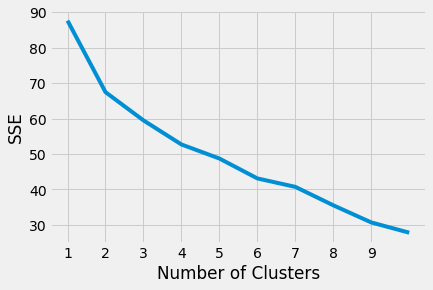

In [35]:
import matplotlib
matplotlib.use
import matplotlib.pyplot as plt

plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 10))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

### Elbow Method: Finding the best K

In [36]:

kl = KneeLocator(range(1,len(sse)+1),sse, curve = "convex", direction = "decreasing")
print("The best kNN Model is using k=",kl.elbow)

The best kNN Model is using k= 4


Now, we will use k = 4 to fit a model for London neighbourhood.

In [37]:
km = KMeans(n_clusters = 4, random_state = 0).fit(london_grouped_clustering)
km.labels_[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 3, 0])

We will now need to create data frame for this model.

In [38]:
neighborhoods_venues_sorted.insert(0, 'Cluster', km.labels_)
london_merged = ldnf_ll
london_merged = london_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on = 'Neighborhood')
london_merged.head()

Neighborhood               Borough  Latitude  Longitude  Cluster  \
0          Barking  Barking and Dagenham   51.5465   0.124986        0   
1       Rush Green  Barking and Dagenham   51.5465   0.124986        0   
2         Dagenham  Barking and Dagenham   51.5465   0.124986        0   
3  Becontree Heath  Barking and Dagenham   51.5465   0.124986        0   
4        Becontree  Barking and Dagenham   51.5465   0.124986        0   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0                  Park          Home Service           Yoga Studio   
1                  Park          Home Service           Yoga Studio   
2                  Park          Home Service           Yoga Studio   
3                  Park          Home Service           Yoga Studio   
4                  Park          Home Service           Yoga Studio   

  4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0            Food Court                Garden           Gaming Cafe   
1            Food Court                Garden           Gaming Cafe   
2            Food Court                Garden           Gaming Cafe   
3            Food Court                Garden           Gaming Cafe   
4            Food Court                Garden           Gaming Cafe   

    7th Most Common Venue    8th Most Common Venue 9th Most Common Venue  \
0  Furniture / Home Store  Fruit & Vegetable Store   Fried Chicken Joint   
1  Furniture / Home Store  Fruit & Vegetable Store   Fried Chicken Joint   
2  Furniture / Home Store  Fruit & Vegetable Store   Fried Chicken Joint   
3  Furniture / Home Store  Fruit & Vegetable Store   Fried Chicken Joint   
4  Furniture / Home Store  Fruit & Vegetable Store   Fried Chicken Joint   

  10th Most Common Venue  
0      French Restaurant  
1      French Restaurant  
2      French Restaurant  
3      French Restaurant  
4      French Restaurant

### Mapping the Clusters

In [39]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

k=4
# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(london_merged['Latitude'], london_merged['Longitude'], london_merged['Neighborhood'], london_merged['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Describing Clusters

Now we will identify the members of each cluster and create a name for the group depending on the common venues the Boroughs have.

#### Cluster 1: Bus Stops, Pub and Supermarkets

In [40]:
k1 = london_merged.loc[london_merged['Cluster'] ==0, london_merged.columns[[1] + list(range(5, london_merged.shape[1]))]]
k1 = k1.sort_values('Borough', ascending=False)
k1 = k1.drop_duplicates(subset='Borough', keep='first')
k1

Borough    1st Most Common Venue  \
524             Westminster              Coffee Shop   
500              Wandsworth                      Pub   
492          Waltham Forest                      Pub   
477           Tower Hamlets                     Park   
463                  Sutton                     Café   
453               Southwark                     Café   
428    Richmond upon Thames                Gastropub   
419               Redbridge              Pizza Place   
405                  Newham                     Café   
393                  Merton             Tram Station   
378                Lewisham        Indian Restaurant   
362                 Lambeth              Coffee Shop   
349    Kingston upon Thames                      Pub   
339  Kensington and Chelsea                    Hotel   
322               Islington                      Pub   
312                Hounslow                 Bus Stop   
296              Hillingdon      Sporting Goods Shop   
260                  Harrow        Afghan Restaurant   
246                Haringey     Fast Food Restaurant   
230  Hammersmith and Fulham                    Hotel   
220                 Hackney       Turkish Restaurant   
188                 Enfield                   Garden   
171                  Ealing                     Park   
169                Dartford              Gas Station   
158                 Croydon                      Pub   
138                  Camden              Coffee Shop   
119                 Bromley     Gym / Fitness Center   
84                    Brent  Scandinavian Restaurant   
51                   Bexley                      Pub   
38                   Barnet              Supermarket   
4      Barking and Dagenham                     Park   

          2nd Most Common Venue     3rd Most Common Venue  \
524              Clothing Store         French Restaurant   
500                        Café                  Bus Stop   
492                     Brewery        Turkish Restaurant   
477         Fried Chicken Joint                       Pub   
463               Grocery Store                      Park   
453                         Pub                    Garden   
428                        Park             Boat or Ferry   
419               Grocery Store         Indian Restaurant   
405                      Market                       Pub   
393                 Pizza Place                       Pub   
378                         Pub                      Café   
362                         Pub              Cocktail Bar   
349                  Taxi Stand              Home Service   
339                   Juice Bar                       Pub   
322           French Restaurant  Mediterranean Restaurant   
312                         Pub         Indian Restaurant   
296  Construction & Landscaping                Playground   
260           Indian Restaurant            Sandwich Place   
246                        Café                  Bus Stop   
230                        Café                       Pub   
220                        Café              Cocktail Bar   
188                 Pizza Place         Indian Restaurant   
171                  Playground             Train Station   
169        Fast Food Restaurant                      Café   
158          Italian Restaurant  Mediterranean Restaurant   
138            Greek Restaurant       Japanese Restaurant   
119         Sporting Goods Shop                      Park   
84                  Supermarket    Furniture / Home Store   
51                  Supermarket                       Bar   
38      Scandinavian Restaurant                  Bus Stop   
4                  Home Service               Yoga Studio   

          4th Most Common Venue   5th Most Common Venue  \
524                       Hotel          Cosmetics Shop   
500               Garden Center               Gastropub   
492      Thrift / Vintage Store                  Museum   
477          Italian Restaurant       

#### Cluster 2: Pub and Restaurants

In [41]:
k2 = london_merged.loc[london_merged['Cluster'] ==1, london_merged.columns[[1] + list(range(5, london_merged.shape[1]))]]
k2 = k2.sort_values('Borough', ascending=False)
k2 = k2.drop_duplicates(subset='Borough', keep='first')
k2

Borough 1st Most Common Venue 2nd Most Common Venue  \
267  Havering                  Park           Yoga Studio   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
267            Food Court                Garden           Gaming Cafe   

      6th Most Common Venue    7th Most Common Venue 8th Most Common Venue  \
267  Furniture / Home Store  Fruit & Vegetable Store   Fried Chicken Joint   

    9th Most Common Venue 10th Most Common Venue  
267     French Restaurant             Food Truck

#### Cluster 3: Park and Recreation

In [42]:
k3 = london_merged.loc[london_merged['Cluster'] ==2, london_merged.columns[[1] + list(range(5, london_merged.shape[1]))]]
k3 = k3.sort_values('Borough', ascending=False)
k3 = k3.drop_duplicates(subset='Borough', keep='first')
k3

Borough 1st Most Common Venue 2nd Most Common Venue  \
319   Hounslow              Bus Stop                   Pub   
203  Greenwich              Bus Stop      Stationery Store   
41      Barnet           Supermarket         Grocery Store   

    3rd Most Common Venue  4th Most Common Venue 5th Most Common Venue  \
319           Coffee Shop  Portuguese Restaurant           Pizza Place   
203          Soccer Field             Distillery            Food Court   
41          Metro Station   Gym / Fitness Center                Bakery   

    6th Most Common Venue 7th Most Common Venue   8th Most Common Venue  \
319     Indian Restaurant   Dumpling Restaurant              Food Court   
203        Discount Store           Gaming Cafe  Furniture / Home Store   
41               Bus Stop            Food Truck                  Garden   

       9th Most Common Venue  10th Most Common Venue  
319              Gaming Cafe  Furniture / Home Store  
203  Fruit & Vegetable Store     Fried Chicken Joint  
41               Gaming Cafe  Furniture / Home Store

#### Cluster 4: Park and Recreation of the South

In [43]:
k4 = london_merged.loc[london_merged['Cluster'] ==3, london_merged.columns[[1] + list(range(5, london_merged.shape[1]))]]
k4 = k4.sort_values('Borough', ascending=False)
k4 = k4.drop_duplicates(subset='Borough', keep='first')
k4

Borough 1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
95  Bromley        Soccer Stadium                  Park  Gym / Fitness Center   

   4th Most Common Venue   5th Most Common Venue    6th Most Common Venue  \
95                Garden  Furniture / Home Store  Fruit & Vegetable Store   

   7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
95   Fried Chicken Joint     French Restaurant            Food Truck   

   10th Most Common Venue  
95             Food Court

#### Which Top 2 clusters that we should consider in building Filipino Fast Food restaurant?

We should consider Cluster 2 since all other competitors are also here. We can also consider Cluster 1 since there are few competitors within a high-potential neighborhood because of the Bus Stops and Supermarkets around.

### Cluster 1 Deep Dive: Bus Stops, Pub and Supermarkets

Merge demography data and Cluster data.

In [44]:
#demo_int.columns
demo_k2 = demo_int.merge(k2, left_on  = 'AREA_NAME',  right_on = 'Borough')
demo_k2

AREA_NAME  GLA_POPULATION_ESTIMATE_2017 POPULATION_DENSITY_PER_HECTARE_2017  \
0  Havering                        254300                                22.6   

   AVERAGE_AGE_2017  PROPORTION_OF_POPULATION_AGED_0_15_2015  \
0              40.3                                     19.3   

   PROPORTION_OF_POPULATION_OF_WORKING_AGE_2015  \
0                                          62.3   

   PROPORTION_OF_POPULATION_AGED_65_AND_OVER_2015  EMPLOYMENT_RATE_2015_  \
0                                            18.4                   76.5   

  UNEMPLOYMENT_RATE_2015_ GROSS_ANNUAL_PAY_2016_  \
0                     5.3                  33398   

  MODELLED_HOUSEHOLD_MEDIAN_INCOME_ESTIMATES_2012_13  \
0                                            £36,670   

  NUMBER_OF_JOBS_BY_WORKPLACE_2014_  JOBS_DENSITY_2015  \
0                             91300                0.6   

   NUMBER_OF_ACTIVE_BUSINESSES_2015  \
0                             10115   

   TWO_YEAR_BUSINESS_SURVIVAL_RATES_STARTED_IN_2013_  \
0                                               75.3   

  CRIME_RATES_PER_THOUSAND_POPULATION_2014_15  \
0                                        62.9   

  FIRES_PER_THOUSAND_POPULATION_2014_  \
0                                 2.5   

  AMBULANCE_INCIDENTS_PER_HUNDRED_POPULATION_2014_  \
0                                             12.9   

  TOTAL_CARBON_EMISSIONS_2014_  NUMBER_OF_CARS_2011_CENSUS_  \
0                         1032                       117634   

  AVERAGE_PUBLIC_TRANSPORT_ACCESSIBILITY_SCORE_2014   Borough  \
0                                               2.5  Havering   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0                  Park           Yoga Studio            Food Court   

  4th Most Common Venue 5th Most Common Venue   6th Most Common Venue  \
0                Garden           Gaming Cafe  Furniture / Home Store   

     7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0  Fruit & Vegetable Store   Fried Chicken Joint     French Restaurant   

  10th Most Common Venue  
0             Food Truck

Data pre-processing for Logistic Regression - Identifying Two-year Business survival rate threshold

Logistic Regression

In [45]:
demo_int.describe()

GLA_POPULATION_ESTIMATE_2017  AVERAGE_AGE_2017  \
count                  3.800000e+01         38.000000   
mean                   3.897766e+06         36.528947   
std                    1.374693e+07          2.479092   
min                    8.800000e+03         31.400000   
25%                    2.422000e+05         35.000000   
50%                    2.905500e+05         36.250000   
75%                    3.327750e+05         38.150000   
max                    6.599910e+07         43.200000   

       PROPORTION_OF_POPULATION_AGED_0_15_2015  \
count                                38.000000   
mean                                 20.068421   
std                                   4.234103   
min                                  11.400000   
25%                                  18.000000   
50%                                  20.550000   
75%                                  21.250000   
max                                  38.500000   

       PROPORTION_OF_POPULATION_OF_WORKING_AGE_2015  \
count                                     38.000000   
mean                                      67.868421   
std                                        4.523996   
min                                       54.700000   
25%                                       64.500000   
50%                                       67.650000   
75%                                       72.000000   
max                                       75.300000   

       PROPORTION_OF_POPULATION_AGED_65_AND_OVER_2015  EMPLOYMENT_RATE_2015_  \
count                                       38.000000              38.000000   
mean                                        12.055263              72.776316   
std                                          3.327664               3.932294   
min                                          6.000000              64.600000   
25%                                          9.400000              69.725000   
50%                                         12.000000              73.150000   
75%                                         14.450000              75.250000   
max                                         18.400000              79.600000   

       JOBS_DENSITY_2015  NUMBER_OF_ACTIVE_BUSINESSES_2015  \
count          38.000000                      3.800000e+01   
mean            3.113158                      1.748426e+05   
std            13.543068                      5.681394e+05   
min             0.400000                      6.560000e+03   
25%             0.600000                      1.222125e+04   
50%             0.700000                      1.534750e+04   
75%             1.000000                      2.125750e+04   
max            84.300000                      2.672025e+06   

       TWO_YEAR_BUSINESS_SURVIVAL_RATES_STARTED_IN_2013_  \
count                                          38.000000   
mean                                           73.781579   
std                                             3.260149   
min                                            63.800000   
25%                                            73.000000   
50%                                            74.400000   
75%                                            75.675000   
max                                            78.800000   

       NUMBER_OF_CARS_2011_CENSUS_  
count                 3.800000e+01  
mean                  1.684820e+06  
std                   6.333514e+06  
min                   1.692000e+03  
25%                   6.060150e+04  
50%                   8.636000e+04  
75%                   1.191482e+05  
max                   3.033310e+07

Looking at the summary tables. The survival rate average is 73.78%. We will use this to re-code survival rate to 0 or 1.

In [46]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import statistics

mean_survival = statistics.mean(demo_int['TWO_YEAR_BUSINESS_SURVIVAL_RATES_STARTED_IN_2013_'])
demo_int.loc[demo_int['TWO_YEAR_BUSINESS_SURVIVAL_RATES_STARTED_IN_2013_'] >=mean_survival, 'business_survival'] = 1
demo_int.loc[demo_int['TWO_YEAR_BUSINESS_SURVIVAL_RATES_STARTED_IN_2013_'] <mean_survival, 'business_survival'] = 0

Now, we will get the cluster subset and run logistic regression

In [47]:
#demo_int.columns
demo_k1 = demo_int.merge(k1, left_on  = 'AREA_NAME',  right_on = 'Borough')
demo_k1.describe()

GLA_POPULATION_ESTIMATE_2017  AVERAGE_AGE_2017  \
count                     30.000000         30.000000   
mean                  276406.666667         36.063333   
std                    62203.253786          2.127567   
min                   159000.000000         31.400000   
25%                   233925.000000         35.000000   
50%                   277100.000000         36.000000   
75%                   326175.000000         37.250000   
max                   389600.000000         40.200000   

       PROPORTION_OF_POPULATION_AGED_0_15_2015  \
count                                30.000000   
mean                                 20.200000   
std                                   2.377336   
min                                  15.900000   
25%                                  18.850000   
50%                                  20.600000   
75%                                  21.250000   
max                                  27.200000   

       PROPORTION_OF_POPULATION_OF_WORKING_AGE_2015  \
count                                     30.000000   
mean                                      68.310000   
std                                        3.852124   
min                                       62.600000   
25%                                       64.900000   
50%                                       67.700000   
75%                                       71.825000   
max                                       75.300000   

       PROPORTION_OF_POPULATION_AGED_65_AND_OVER_2015  EMPLOYMENT_RATE_2015_  \
count                                       30.000000              30.000000   
mean                                        11.483333              72.880000   
std                                          2.914776               4.103522   
min                                          6.000000              65.600000   
25%                                          9.300000              69.275000   
50%                                         11.700000              73.150000   
75%                                         13.175000              75.375000   
max                                         17.500000              79.600000   

       JOBS_DENSITY_2015  NUMBER_OF_ACTIVE_BUSINESSES_2015  \
count          30.000000                         30.000000   
mean            0.940000                      16500.166667   
std             0.749529                       8954.467338   
min             0.400000                       6560.000000   
25%             0.600000                      12221.250000   
50%             0.700000                      14472.500000   
75%             1.000000                      18112.500000   
max             4.300000                      55385.000000   

       TWO_YEAR_BUSINESS_SURVIVAL_RATES_STARTED_IN_2013_  \
count                                          30.000000   
mean                                           74.070000   
std                                             3.128308   
min                                            63.800000   
25%                                            73.400000   
50%                                            74.400000   
75%                                            75.950000   
max                                            78.800000   

       NUMBER_OF_CARS_2011_CENSUS_  business_survival  
count                    30.000000          30.000000  
mean                  82230.100000           0.600000  
std                   32742.480238           0.498273  
min                   38629.000000           0.000000  
25%                   57834.000000           0.000000  
50%                   76362.000000           1.000000  
75%                  104835.750000           1.000000  
max                  153908.000000           1.000000

In [48]:
demo_int['business_survival'] = demo_int['business_survival'].astype(int)
y = np.asarray(demo_int['business_survival'])
X = np.asarray(demo_int[['GLA_POPULATION_ESTIMATE_2017','AVERAGE_AGE_2017','PROPORTION_OF_POPULATION_AGED_0_15_2015','PROPORTION_OF_POPULATION_OF_WORKING_AGE_2015','PROPORTION_OF_POPULATION_AGED_65_AND_OVER_2015','EMPLOYMENT_RATE_2015_','JOBS_DENSITY_2015','NUMBER_OF_ACTIVE_BUSINESSES_2015','NUMBER_OF_CARS_2011_CENSUS_']])
X[0:5]


array([[8.80000e+03, 4.32000e+01, 1.14000e+01, 7.31000e+01, 1.55000e+01,
        6.46000e+01, 8.43000e+01, 2.61300e+04, 1.69200e+03],
       [2.09000e+05, 3.29000e+01, 2.72000e+01, 6.31000e+01, 9.70000e+00,
        6.58000e+01, 5.00000e-01, 6.56000e+03, 5.69660e+04],
       [3.89600e+05, 3.73000e+01, 2.11000e+01, 6.49000e+01, 1.40000e+01,
        6.85000e+01, 7.00000e-01, 2.61900e+04, 1.44717e+05],
       [2.44300e+05, 3.90000e+01, 2.06000e+01, 6.29000e+01, 1.66000e+01,
        7.51000e+01, 6.00000e-01, 9.07500e+03, 1.08507e+05],
       [3.32100e+05, 3.56000e+01, 2.09000e+01, 6.78000e+01, 1.13000e+01,
        6.95000e+01, 6.00000e-01, 1.57450e+04, 8.78020e+04]])

In [49]:

from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X)

In [50]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (30, 9) (30,)
Test set: (8, 9) (8,)


In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR

LogisticRegression(C=0.01, solver='liblinear')

In [52]:
yhat = LR.predict(X_test)
yhat

array([0, 0, 1, 1, 0, 0, 0, 0])

In [53]:
yhat_prob = LR.predict_proba(X_test)
yhat_prob

array([[0.50057594, 0.49942406],
       [0.5359772 , 0.4640228 ],
       [0.42906243, 0.57093757],
       [0.49671997, 0.50328003],
       [0.57043923, 0.42956077],
       [0.55831876, 0.44168124],
       [0.52376548, 0.47623452],
       [0.52948019, 0.47051981]])

In [54]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(y_test, yhat, labels=[1,0]))

[[2 3]
 [0 3]]


In [55]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['above_average=1','below_average=0'],normalize= False,  title='Confusion matrix')

Confusion matrix, without normalization
[[2 3]
 [0 3]]


In [56]:
print (classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67         3
           1       1.00      0.40      0.57         5

    accuracy                           0.62         8
   macro avg       0.75      0.70      0.62         8
weighted avg       0.81      0.62      0.61         8



## Results and Discussion: Understanding Pub and Restaurants <a name="Results and Discussion"></a>

AFter identifying neighborhoods and demographic variables in London, United Kingdom, best K-cluster is identified. We can see here that the best number of clusters is 4 using the elbow method. Using K Means clustering, we have identified the unique characteristics of each clusters and focused on Busy streets wherein there are Bus Stops and Supermarkets. 

Deep diving to this cluster we did logistic regression to identify the probability of above average two-year business survival rate in this cluster. The average business survival rate here is at 78% at 62% accuracy. It is notable that the variables used only yields to 62% accuracy and was able to predict True Positves at 25%. Checking at the predicted probability. We can see at an average of 50% survival when building a food restaurant in this cluster.

## Conclusion <a name="Conclusion"></a>

I therefore conclude that the best k-means cluster for London, United Kingdom is 4. It also shows that the demographic variables is not accurate enough to predict whether a business can survive in a particular cluster.
It is suggested to dig deep to other clusters and identify the probabilit of survival rate of the business. It is also much likely to predict more accurately with other demography data of London, United Kingdom.
